## Imports

In [218]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import glob

import cv2
import scipy

# create a venv >> python -m venv .venv
# activate the venv >> .venv\Scripts\activate
# install opencv >> pip install opencv-python
# >> pip install ipykernel numpy matplotlib
# >> python -m ipykernel install --user --name=stereo_vision --display-name="StereoVision (venv)"

#### Helper Functions

In [219]:
# ----- Helpers --------
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return np.uint8(gray)


def vector_product_cours(v):
        v = v.flatten()[:3]
        return np.array([
            [0,     -v[2],  v[1]],
            [v[2],   0,    -v[0]],
            [-v[1],  v[0],  0   ]
        ])


## Chessboard

#### Chosen Images

In [220]:
# We choose c4 as it has the most planar perspective
chosen_img_left = "c4Left.png"
chosen_img_right = "c4Right.png"

# chosen_img_left = "c2Left.png"
# chosen_img_right = "c2Right.png"

# chosen_img_left = "c3Left.png"       #! Doesn't detect...
# chosen_img_right = "c3Right.png"

# chosen_img_left = "c1Left.png"
# chosen_img_right = "c1Right.png"



### Docs

In [221]:
### Documentation :


# cv2.findChessboardCorners(): This function is used to find the chessboard corners in an image.
    # https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a

# cv2.cornerSubPix(): This function will improve precision of corner's positions.    
    # https://docs.opencv.org/4.0.0/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e

# cv2.drawChessboardCorners(): This function will draw found corners for visual validation purpose. 
    # https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#ga6a10b0bb120c4907e5eabbcd22319022

# cv2.calibrateCamera(): This function will compute rotation vectors, and , based on corners found on multiple chessboards.
    # https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html#ga3207604e4b1a1758aa66acb6ed5aa65d

### Implementation

In [222]:
def detect_chessboard_corners(image_path, pattern_size=(7, 7)):
    """
    Detect corners in an image and return results for display.
    """
    # Read
    img = cv2.imread(image_path)
        
    # Convert to grayscale
    grey = rgb2gray(img)
    
    # Find chessboard corners
    retval, corners = cv2.findChessboardCorners(img, pattern_size, None)
    
    # Prepare result dictionary
    result = {
        'success': retval,
        'image_rgb': cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
        'corners': None,
        'image_with_corners': cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    }
    
    if retval:
        # Improve corner precision
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        refined_corners = cv2.cornerSubPix(grey, corners, (11, 11), (-1, -1), criteria)
        
        # Draw corners on a copy of the image
        img_with_corners = img.copy()
        cv2.drawChessboardCorners(img_with_corners, pattern_size, refined_corners, retval)
        
        # Update result
        result['corners'] = refined_corners
        result['image_with_corners'] = cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB)
    
    return result

#### Example

Corners detected successfully in both images!
Left image corners shape: (49, 1, 2)
Right image corners shape: (49, 1, 2)


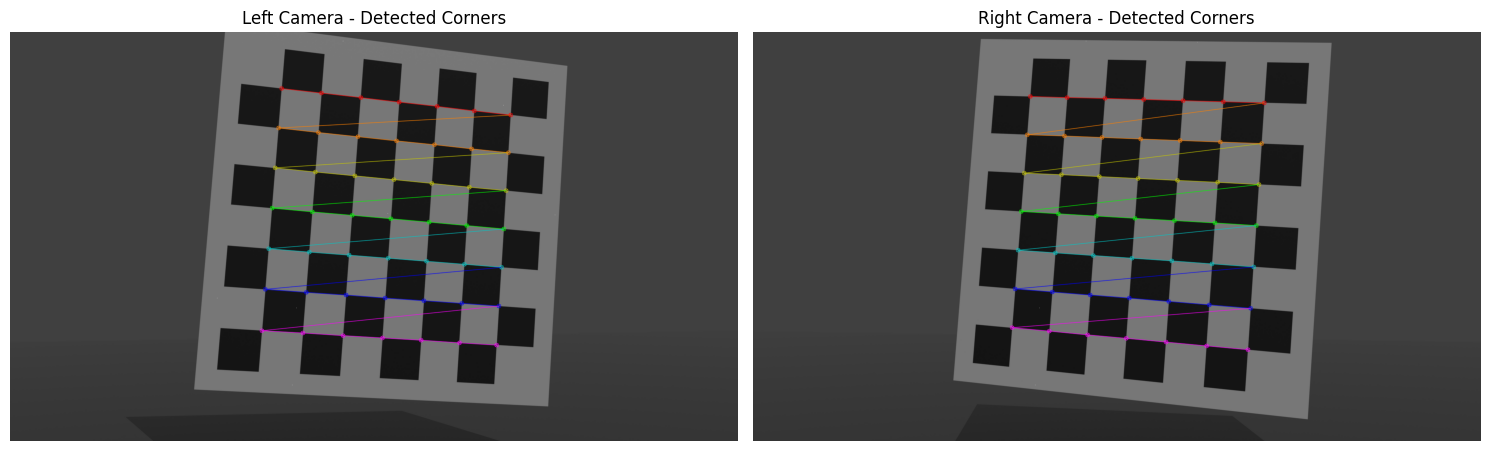

In [223]:
# EXAMPLE: set of one L/R images
result_left = detect_chessboard_corners(f"./chessboards/{chosen_img_left}")
result_right = detect_chessboard_corners(f"./chessboards/{chosen_img_right}")

# Display results
if result_left['success'] and result_right['success']:
    print("Corners detected successfully in both images!")
    print(f"Left image corners shape: {result_left['corners'].shape}")
    print(f"Right image corners shape: {result_right['corners'].shape}")
else:
    print(f"Corner detection - Left: {result_left['success']}, Right: {result_right['success']}")


# ====================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Display left image with corners
ax1.imshow(result_left['image_with_corners'])
ax1.set_title('Left Camera - Detected Corners')
ax1.axis('off')

# Display right image with corners
ax2.imshow(result_right['image_with_corners'])
ax2.set_title('Right Camera - Detected Corners')
ax2.axis('off')

plt.tight_layout()
plt.show()

### Camera Calibration

In [224]:
# INPUT:
    # objectPoints: Vector of vectors of calibration pattern points in the calibration pattern coordinate space.
    # imagePoints: 	Vector of vectors of the projections of calibration pattern points.
    # imageSize: Size of the image used only to initialize the intrinsic camera matrix.

# OUTPUT:
    # retval: RMS reprojection error
    # cameraMatrix:  Refined camera intrinsic matrix
    # distCoeffs: Output vector of distortion coefficients.
    # rvecs: Output vector of rotation vectors
    # tvecs 

def calibrate_camera(img_list, pattern_size):
    objp = np.zeros((pattern_size[0] * pattern_size[1], 3), np.float32)            # Shape: (49, 3) for 7×7 corners
    objp[:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)  # copy objp for each image
    object_points = []  # 3D points in real world space
    image_points = []   # 2D points in image plane
    successful_images = [] 

    for i in img_list:
        result = detect_chessboard_corners(i, pattern_size)
        if result["success"]:
            object_points.append(objp)
            image_points.append(result["corners"])
            successful_images.append(i)

    # Get image size from the first image
    first_img = cv2.imread(img_list[0])
    image_size = (first_img.shape[1], first_img.shape[0])  # (width, height)
        #print(f"Image size: {image_size}")

    # Calibrate camera
    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        object_points, 
        image_points, 
        image_size, 
        None,  # Let OpenCV estimate initial camera matrix
        None   # Let OpenCV estimate initial distortion coefficients
    )

    return ret, camera_matrix, dist_coeffs, rvecs, tvecs, successful_images

# More images passed -> better results
# Pass a list of images, receive a list of Projection Matrixes P.
# Choose the final P and P' based on the image with the orientation the most similar to final 3D image (here c4.png)

#### Example

In [225]:
# Load images
img_list = glob.glob("./chessboards/C4*.png")
print("Found images:", len(img_list))

# Get Results
result = calibrate_camera(img_list, (7,7))
ret, camera_matrix, dist_coeffs, rvecs, tvecs, successful_images = result
print(f"Successfully calibrated on {len(successful_images)} images.")

# Find indices
left_idx = next(i for i, path in enumerate(successful_images) if chosen_img_left in path)
right_idx = next(i for i, path in enumerate(successful_images) if chosen_img_right in path)

# Extract parameters for both
ret_left, mtx_left, dist_left = ret, camera_matrix, dist_coeffs
rvec_left, tvec_left = rvecs[left_idx], tvecs[left_idx]

ret_right, mtx_right, dist_right = ret, camera_matrix, dist_coeffs  
rvec_right, tvec_right = rvecs[right_idx], tvecs[right_idx]

# Display results
print(f"Left: rvec={rvec_left.flatten()}, tvec={tvec_left.flatten()}")
print(f"Right: rvec={rvec_right.flatten()}, tvec={tvec_right.flatten()}")


Found images: 2
Successfully calibrated on 2 images.
Left: rvec=[-0.06195956 -0.18333823  0.07810289], tvec=[-2.28797749 -3.64033621 20.04354425]
Right: rvec=[-0.04710054  0.21783908  0.06865165], tvec=[-2.24506232 -3.59326992 20.93162404]


### Projection Matrixes

In [226]:
# Why ? encode how points in the 3D world are mapped to the 2D image planes of each camera.

# Camera Calibration gave us our rotation and translation vectors for both cameras...

# Convert rotation vectors to rotation matrices
R_left, _ = cv2.Rodrigues(rvec_left)   # 3x3 rotation matrix
R_right, _ = cv2.Rodrigues(rvec_right) # 3x3 rotation matrix

# Build extrinsic matrices [R|t] (3x4)
RT_left = np.hstack([R_left, tvec_left.reshape(-1, 1)])
RT_right = np.hstack([R_right, tvec_right.reshape(-1, 1)]) 

# Build projection matrices P = K * [R|t] //  P_ext = P_int * (R T) (3x4)
P_left = camera_matrix @ RT_left
P_right = camera_matrix @ RT_right  #camera_matrix from calibrate_camera()

print("Left Projection Matrix P:")
print(P_left)
print("\nRight Projection Matrix P':")
print(P_right)
print(f"\nCheck dimensions ok (3x4): P_left={P_left.shape}, P_right={P_right.shape}")


Left Projection Matrix P:
[[ 2.25490322e+03 -2.18533420e+02  5.48972174e+02  1.43545506e+04]
 [ 2.73045727e+02  2.07635312e+03  6.42006129e+02  3.02310971e+03]
 [ 1.79599491e-01 -6.86444748e-02  9.81341917e-01  2.00435442e+01]]

Right Projection Matrix P':
[[ 1.86108678e+03 -1.93011749e+02  1.39025835e+03  1.52971459e+04]
 [ 1.69462971e+01  2.09532306e+03  6.38202305e+02  3.59955132e+03]
 [-2.17479351e-01 -3.92310932e-02  9.75276193e-01  2.09316240e+01]]

Check dimensions ok (3x4): P_left=(3, 4), P_right=(3, 4)


#### Verification

In [227]:
# ================ CHECK ========================

# 1. Check if decomposition gives back original matrices
print("=== 1. MATRIX DECOMPOSITION CHECK ===")
K_left_check, R_left_check, t_left_check, _, _, _, _ = cv2.decomposeProjectionMatrix(P_left)
K_right_check, R_right_check, t_right_check, _, _, _, _ = cv2.decomposeProjectionMatrix(P_right)

# Normalize K matrices (they come back scaled)
K_left_check = K_left_check / K_left_check[2, 2]
K_right_check = K_right_check / K_right_check[2, 2]
camera_matrix_norm = camera_matrix / camera_matrix[2, 2]
# print(f"Original K:\n{camera_matrix_norm}")
# print(f"Decomposed K (left):\n{K_left_check}")
print(f"K_left matrices match: {np.allclose(camera_matrix_norm, K_left_check, atol=1e-3)}")
print(f"K_right matrices match: {np.allclose(camera_matrix_norm, K_right_check, atol=1e-3)}")

# 2. Check rotation matrix properties
print("\n=== 2. ROTATION MATRIX VALIDATION ===")
det_R_left = np.linalg.det(R_left)
det_R_right = np.linalg.det(R_right)
print(f"det(R_left) = {det_R_left:.6f} (should be ≈ 1.0)")
print(f"det(R_right) = {det_R_right:.6f} (should be ≈ 1.0)")

# Check orthogonality: R @ R.T should be identity
ortho_left = np.allclose(R_left @ R_left.T, np.eye(3), atol=1e-6)
ortho_right = np.allclose(R_right @ R_right.T, np.eye(3), atol=1e-6)
print(f"R_left is orthogonal: {ortho_left}")
print(f"R_right is orthogonal: {ortho_right}")

# 3. Check camera centers and baseline
print("\n=== 3. CAMERA GEOMETRY ===")
C_left = -R_left.T @ tvec_left.reshape(-1, 1)
C_right = -R_right.T @ tvec_right.reshape(-1, 1)
baseline = np.linalg.norm(C_left - C_right)

print(f"Left camera center: {C_left.flatten()}")
print(f"Right camera center: {C_right.flatten()}")
print(f"Baseline distance: {baseline:.4f}")
print(f"Baseline OK (>0.01): {baseline > 0.01}")

# 4. CRITICAL: Reprojection error test
print("\n=== 4. REPROJECTION ERROR TEST ===")

# Create 3D chessboard points
objp = np.zeros((7 * 7, 3), np.float32)
objp[:,:2] = np.mgrid[0:7, 0:7].T.reshape(-1, 2)
objp_homogeneous = np.hstack([objp, np.ones((objp.shape[0], 1))]).T  # 4x49

# Project using P matrices
projected_left = P_left @ objp_homogeneous
projected_left = (projected_left[:2, :] / projected_left[2, :]).T  # Convert to 2D

projected_right = P_right @ objp_homogeneous
projected_right = (projected_right[:2, :] / projected_right[2, :]).T

# Get detected corners for comparison
if 'result_left' in locals() and result_left['success']:
    detected_left = result_left['corners'].reshape(-1, 2)
    detected_right = result_right['corners'].reshape(-1, 2)
    
    # Calculate reprojection errors
    error_left = np.linalg.norm(projected_left - detected_left, axis=1)
    error_right = np.linalg.norm(projected_right - detected_right, axis=1)
    
    print(f"Left camera  - Mean error: {np.mean(error_left):.3f} px, Max: {np.max(error_left):.3f} px")
    print(f"Right camera - Mean error: {np.mean(error_right):.3f} px, Max: {np.max(error_right):.3f} px")
    
    # Overall validation result
    validation_ok = (np.mean(error_left) < 3.0 and np.mean(error_right) < 3.0 and 
                    baseline > 0.01 and ortho_left and ortho_right)
    
    print(f"\n=== OVERALL VALIDATION: {'✓ PASS' if validation_ok else '✗ FAIL'} ===")
    
    if not validation_ok:
        print("Issues detected:")
        if np.mean(error_left) >= 3.0 or np.mean(error_right) >= 3.0:
            print("- High reprojection error: P matrices incorrect")
        if baseline <= 0.01:
            print("- Baseline too small: cameras too close or calibration failed")
        if not ortho_left or not ortho_right:
            print("- Invalid rotation matrices")
else:
    print("ERROR: No corner detection results available for comparison")



=== 1. MATRIX DECOMPOSITION CHECK ===
K_left matrices match: True
K_right matrices match: True

=== 2. ROTATION MATRIX VALIDATION ===
det(R_left) = 1.000000 (should be ≈ 1.0)
det(R_right) = 1.000000 (should be ≈ 1.0)
R_left is orthogonal: True
R_right is orthogonal: True

=== 3. CAMERA GEOMETRY ===
Left camera center: [ -1.05423656   4.83373433 -19.89357063]
Right camera center: [  6.96506754   4.23784393 -19.73862435]
Baseline distance: 8.0429
Baseline OK (>0.01): True

=== 4. REPROJECTION ERROR TEST ===
Left camera  - Mean error: 0.042 px, Max: 0.076 px
Right camera - Mean error: 0.044 px, Max: 0.075 px

=== OVERALL VALIDATION: ✓ PASS ===


#### 3D - Reconstruction (P matrixes)

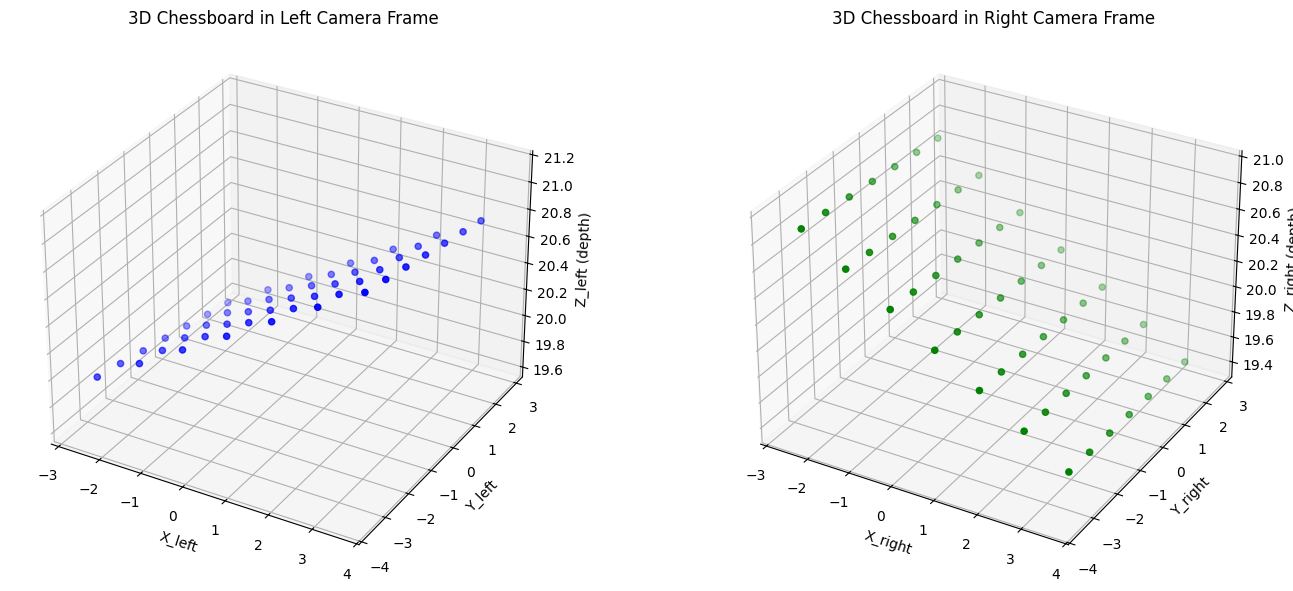

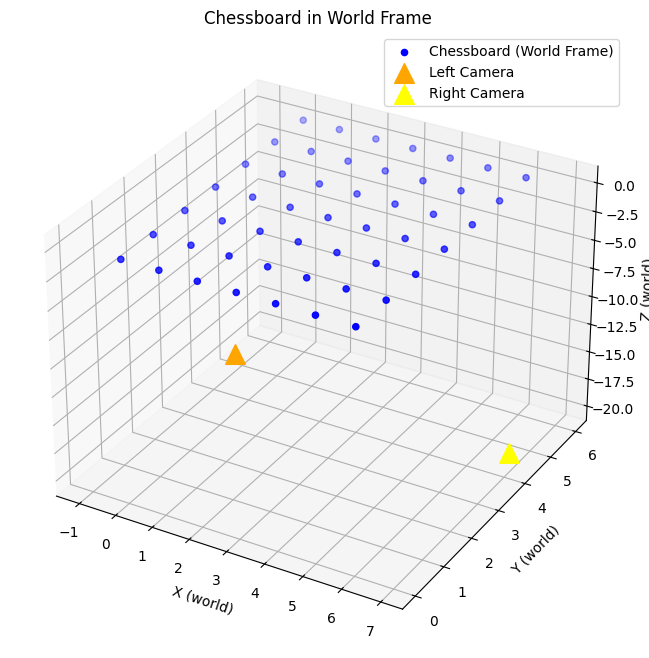

In [ ]:
result_left = detect_chessboard_corners(f"./chessboards/{chosen_img_left}")
result_right = detect_chessboard_corners(f"./chessboards/{chosen_img_right}")

if result_left['success'] and result_right['success']:
    corners_left = result_left['corners']
    corners_right = result_right['corners']

    # Triangulate (OpenCV expects 2xN arrays)
    X_hom = cv2.triangulatePoints(P_left, P_right, corners_left.reshape(-1,2).T, corners_right.reshape(-1,2).T)
    X = (X_hom[:3] / X_hom[3]).T  # Nx3

    # Express to Camera Frame (triangulatePoints is in board 2D frame)
    X_left_cam = (R_left @ X.T + tvec_left.reshape(3, 1)).T
    X_right_cam = (R_right @ X.T + tvec_right.reshape(3, 1)).T

    # ============================================================

    # 3D scatter: left and right camera frames side by side
    # World->camera: x_cam = R * X_world + t
    fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(15, 6))
    ax1.scatter(X_left_cam[:, 0], X_left_cam[:, 1], X_left_cam[:, 2], c='b', marker='o')
    ax1.set_title('3D Chessboard in Left Camera Frame')
    ax1.set_xlabel('X_left')
    ax1.set_ylabel('Y_left')
    ax1.set_zlabel('Z_left (depth)')

    ax2.scatter(X_right_cam[:, 0], X_right_cam[:, 1], X_right_cam[:, 2], c='g', marker='o')
    ax2.set_title('3D Chessboard in Right Camera Frame')
    ax2.set_xlabel('X_right')
    ax2.set_ylabel('Y_right')
    ax2.set_zlabel('Z_right (depth)')

    plt.tight_layout()
    plt.show()


    # ====== World coordinates ======
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')  

    # Plot chessboard in world frame - THIS WILL BE FLAT
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c='blue', marker='o', label='Chessboard (World Frame)')

    # Optional: Add camera positions
    ax.scatter(C_left[0], C_left[1], C_left[2], c='orange', marker='^', s=200, label='Left Camera')
    ax.scatter(C_right[0], C_right[1], C_right[2], c='red', marker='^', s=200, label='Right Camera')

    ax.set_xlabel('X (world)')
    ax.set_ylabel('Y (world)')
    ax.set_zlabel('Z (world)')
    ax.legend()
    plt.title('Chessboard in World Frame')
    plt.show()



### Fundamental Matrix

#### With OpenCV

In [229]:
# Consider prime is right, non-prime is left.

def F_mat_opencv(pts_left, pts_right, method=cv2.FM_8POINT):
    # Compute fundamental matrix using OpenCV
    #https://docs.opencv.org/3.4/d9/d0c/group__calib3d.html#ga59b0d57f46f8677fb5904294a23d404a
    F_opencv, mask = cv2.findFundamentalMat(pts_left, pts_right, method)
    return F_opencv, mask


def get_chess_F_mat_opencv():
    # Extract corresponding points from c4 images for OpenCV method
    result_left= detect_chessboard_corners(f"./chessboards/{chosen_img_left}")
    result_right = detect_chessboard_corners(f"./chessboards/{chosen_img_right}")

    if result_left['success'] and result_right['success']:
        # Get corresponding corner points
        pts_left = result_left['corners'].reshape(-1, 2)
        pts_right = result_right['corners'].reshape(-1, 2)

        F_opencv, mask = F_mat_opencv(pts_left, pts_right)
        
        print("========= Fundamental Matrix F (OpenCV): ==========")
        print(F_opencv)

        # Check Epipolar constraint for all inlier points
        print(f"Inliers (epipolar constraint checks): {np.sum(mask)} / {len(mask)} passed.")
    return F_opencv, mask

F_opencv, _ = get_chess_F_mat_opencv()

========= Fundamental Matrix F (OpenCV): ==========
[[ 5.35507591e-07  8.63174326e-07 -3.87684607e-03]
 [-7.21978573e-08  1.23537906e-09 -4.05108147e-03]
 [ 2.32729981e-03  3.29236934e-03  1.00000000e+00]]
Inliers (epipolar constraint checks): 49 / 49 passed.


#### Manually

In [230]:
# Theoretical computation of F :

def F_mat_manual(P_left, P_right, R_left, R_right, tvec_left, tvec_right):
    """ Equation: F = [e']× · P' · P⁺ 
    
    Consider prime is right, non-prime is left.

    1. Find C, C
    2. Find e'
    3. Find [e']×
    4. Find P⁺
    5. Compute F
    
    """
    # 1. Camera's optical centers (T = -R @ C  <=> C = -R^T @ T)
    C_left = -R_left.T @ tvec_left.reshape(-1, 1)      # reshape: turns [x, y, z] into [[x], [y], [z]]
    C_left_homogeneous = np.vstack((C_left, 1))       # Convert C_left to homogeneous coordinates (add rows of 1's)
    C_right = -R_right.T @ tvec_right.reshape(-1, 1)

    # 2. e': epipole
    e_prime = P_right @ C_left_homogeneous

    # 3. [e']×
    e_prime_cross = vector_product_cours(e_prime)

    # P⁺: Pseudo-inverse of P  : https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html
    P_left_pinv = np.linalg.pinv(P_left)  # 4x3 (inverse of 3x4)

    # Fundamental matrix computation
    F_manual = e_prime_cross @ P_right @ P_left_pinv 

    return F_manual

def get_chess_F_mat_manual():
    F_manual = F_mat_manual(P_left, P_right, R_left, R_right, tvec_left, tvec_right)
    
    print("========= Fundamental Matrix F (Manual): ==========")
    print(F_manual)
    
    # # Compute epipole position for diagnostics
    # C_left = -R_left.T @ tvec_left.reshape(-1, 1)
    # C_left_hom = np.vstack([C_left, [[1]]])
    # e_prime = P_right @ C_left_hom
    # e_prime_2d = e_prime[:2] / e_prime[2]
    
    # print(f"\nDiagnostics:")
    # print(f"  Epipole in right image: ({e_prime_2d[0, 0]:.1f}, {e_prime_2d[1, 0]:.1f})")
    # print(f"  Matrix determinant: {np.linalg.det(F_manual):.2e} (should be ≈ 0)")
    
    return F_manual

F_manual = get_chess_F_mat_manual()


========= Fundamental Matrix F (Manual): ==========
[[-2.62550465e-04 -1.56954713e+00  1.01376716e+03]
 [-1.63321577e+00 -1.07067248e-03  1.82986486e+04]
 [ 1.05237584e+03 -1.52544258e+04 -1.96622592e+06]]


#### Comparison

In [231]:

def compute_epiline_angles(F, points):
    """
    Compute angles of epilines from horizontal.
    
    Args:
        F: 3x3 fundamental matrix
        points: Nx2 array of points in left image
    
    Returns:
        numpy array of angles in degrees [-90, 90]
    """
    epilines = get_epilines(F, points)
    angles = []
    
    for line in epilines:
        a, b, c = line
        angle_rad = np.arctan2(a, -b)
        angle_deg = np.degrees(angle_rad)
        
        # Normalize to [-90, 90] range
        if angle_deg > 90:
            angle_deg -= 180
        elif angle_deg < -90:
            angle_deg += 180
        
        angles.append(angle_deg)
    
    return np.array(angles)


def check_epipolar_constraint(F, pts_left, pts_right):
    """
    Compute epipolar constraint errors: x_right^T · F · x_left = 0
    
    Args:
        F: 3x3 fundamental matrix
        pts_left: Nx2 array of points in left image
        pts_right: Nx2 array of corresponding points in right image
    
    Returns:
        numpy array of absolute errors for each point pair
    """
    pts_left_hom = np.hstack([pts_left, np.ones((len(pts_left), 1))])
    pts_right_hom = np.hstack([pts_right, np.ones((len(pts_right), 1))])
    
    errors = []
    for i in range(len(pts_left_hom)):
        error = pts_right_hom[i:i+1] @ F @ pts_left_hom[i:i+1].T
        errors.append(abs(error[0, 0]))
    
    return np.array(errors)


def compute_epipole_location(F, C_left, P_right, img_shape):
    """
    Find epipole location in right image.
    
    Args:
        F: 3x3 fundamental matrix
        C_left: 3x1 left camera center
        P_right: 3x4 right projection matrix
        img_shape: tuple (height, width) of right image
    
    Returns:
        dict with keys: 'position' (x, y), 'inside_image' (bool)
    """
    C_left_hom = np.vstack([C_left, [[1]]])
    epipole_hom = P_right @ C_left_hom
    epipole_2d = (epipole_hom[:2] / epipole_hom[2]).flatten()
    
    img_h, img_w = img_shape
    inside = (0 <= epipole_2d[0] <= img_w) and (0 <= epipole_2d[1] <= img_h)
    
    return {
        'position': epipole_2d,
        'inside_image': inside
    }


def compute_relative_rotation(R_left, R_right):
    R_relative = R_right @ R_left.T
    
    # Extract Euler angles
    from scipy.spatial.transform import Rotation as Rot
    r = Rot.from_matrix(R_relative)
    euler_deg = r.as_euler('xyz', degrees=True)
    
    # Check if approximately identity (parallel cameras)
    is_parallel = np.allclose(R_relative, np.eye(3), atol=0.1)
    
    return {
        'matrix': R_relative,
        'euler_angles': euler_deg,
        'is_parallel': is_parallel
    }


def compute_baseline_info(C_left, C_right):
    """
    Compute baseline distance and direction between cameras.
    
    Args:
        C_left: 3x1 left camera center
        C_right: 3x1 right camera center
    
    Returns:
        dict with keys: 'vector', 'distance', 'primarily_horizontal'
    """
    baseline_vector = (C_right - C_left).flatten()
    baseline_distance = np.linalg.norm(baseline_vector)
    
    # Check if baseline is primarily horizontal (X direction)
    primarily_horizontal = (abs(baseline_vector[0]) > abs(baseline_vector[1]) and 
                           abs(baseline_vector[0]) > abs(baseline_vector[2]))
    
    return {
        'vector': baseline_vector,
        'distance': baseline_distance,
        'primarily_horizontal': primarily_horizontal
    }


def verify_fundamental_matrix(  F, pts_left, pts_right, 
                                R_left, R_right, C_left, C_right, 
                                P_right, img_shape, verbose=True    ):
    results = {}
    
    # 1. Epipolar constraint errors
    errors = check_epipolar_constraint(F, pts_left, pts_right)
    results['epipolar_errors'] = {
        'mean': np.mean(errors),
        'max': np.max(errors),
        'all_pass': np.all(errors < 0.01)
    }
    
    # 2. Epiline angles
    sample_points = pts_left[::5]  # Sample every 5th point
    angles = compute_epiline_angles(F, sample_points)
    results['epiline_angles'] = {
        'mean': np.mean(angles),
        'std': np.std(angles),
        'min': np.min(angles),
        'max': np.max(angles),
        'nearly_horizontal': abs(np.mean(angles)) < 5.0
    }
    
    # 3. Epipole location
    epipole_info = compute_epipole_location(F, C_left, P_right, img_shape)
    results['epipole'] = epipole_info
    
    # 4. Matrix determinant (should be ≈ 0)
    det = np.linalg.det(F)
    results['determinant'] = {
        'value': det,
        'nearly_zero': abs(det) < 1e-6
    }
    
    # 5. Relative rotation
    rotation_info = compute_relative_rotation(R_left, R_right)
    results['relative_rotation'] = rotation_info
    
    # 6. Baseline
    baseline_info = compute_baseline_info(C_left, C_right)
    results['baseline'] = baseline_info
    
    # 7. Overall assessment
    all_checks_pass = (
        results['epipolar_errors']['all_pass'] and
        results['determinant']['nearly_zero'] and
        results['baseline']['distance'] > 0.01
    )
    results['overall_pass'] = all_checks_pass
    
    # Print results if verbose
    if verbose:
        print("="*70)
        # print(f"FUNDAMENTAL MATRIX VERIFICATION: {F}")
        # print("="*70)
        
        print("\n1. EPIPOLAR CONSTRAINT (x_right^T · F · x_left = 0)")
        print(f"   Mean error: {results['epipolar_errors']['mean']:.6f}")
        print(f"   Max error:  {results['epipolar_errors']['max']:.6f}")
        print(f"   All < 0.01: {results['epipolar_errors']['all_pass']}")
        print(f"   Status: {'OK' if results['epipolar_errors']['all_pass'] else 'Error'}")
        
        print("\n2. EPILINE ANGLES")
        print(f"   Mean: {results['epiline_angles']['mean']:.2f}°")
        print(f"   Std:  {results['epiline_angles']['std']:.2f}°")
        print(f"   Range: [{results['epiline_angles']['min']:.2f}°, {results['epiline_angles']['max']:.2f}°]")
        print(f"   Nearly horizontal: {results['epiline_angles']['nearly_horizontal']}")
        print(f"   Status: {'OK' if results['epiline_angles']['nearly_horizontal'] else 'Error'}")
        
        print("\n3. EPIPOLE LOCATION")
        pos = results['epipole']['position']
        print(f"   Position: ({pos[0]:.1f}, {pos[1]:.1f})")
        print(f"   Inside image: {results['epipole']['inside_image']}")
        if results['epipole']['inside_image']:
            print(f"   Note: Epipole inside image → cameras are verged (epilines converge)")
        
        print("\n4. MATRIX DETERMINANT")
        print(f"   det(F) = {results['determinant']['value']:.2e}")
        print(f"   Nearly zero: {results['determinant']['nearly_zero']}")
        print(f"   Status: {'OK' if results['determinant']['nearly_zero'] else 'Error'}")
        
        print("\n5. RELATIVE ROTATION")
        euler = results['relative_rotation']['euler_angles']
        print(f"   Euler angles (XYZ): [{euler[0]:.2f}°, {euler[1]:.2f}°, {euler[2]:.2f}°]")
        print(f"   Cameras parallel: {results['relative_rotation']['is_parallel']}")
        
        print("\n6. BASELINE")
        vec = results['baseline']['vector']
        print(f"   Vector: [{vec[0]:.3f}, {vec[1]:.3f}, {vec[2]:.3f}]")
        print(f"   Distance: {results['baseline']['distance']:.4f}")
        print(f"   Primarily horizontal: {results['baseline']['primarily_horizontal']}")
        print(f"   Status: {'OK' if results['baseline']['distance'] > 0.01 else 'Error'}")
        
        print("\n" + "="*70)
        print(f"OVERALL: {'OK' if all_checks_pass else 'Error'}")
        print("="*70 + "\n")
    
    return results



# ==================================================
# Get test points from chessboard
result_left = detect_chessboard_corners(f"./chessboards/{chosen_img_left}")
result_right = detect_chessboard_corners(f"./chessboards/{chosen_img_right}")
pts_left = result_left['corners'].reshape(-1, 2)
pts_right = result_right['corners'].reshape(-1, 2)

# ====== F_opencv ========
print("Testing F_opencv:")
results_opencv = verify_fundamental_matrix(
    F_opencv, pts_left, pts_right,
    R_left, R_right, C_left, C_right,
    P_right, img_test_right_rgb.shape[:2],
    verbose=True
)
# ====== F_manual ========
print("\n\nTesting F_manual:")
results_manual = verify_fundamental_matrix(
    F_manual, pts_left, pts_right,
    R_left, R_right, C_left, C_right,
    P_right, img_test_right_rgb.shape[:2],
    verbose=True
)

# Compare
if results_opencv['overall_pass'] and results_manual['overall_pass']:
    print("✓ Both F matrices are valid!")


Testing F_opencv:
Computed 10 epipolar lines.

1. EPIPOLAR CONSTRAINT (x_right^T · F · x_left = 0)
   Mean error: 0.000136
   Max error:  0.000485
   All < 0.01: True
   Status: OK

2. EPILINE ANGLES
   Mean: -35.42°
   Std:  2.00°
   Range: [-39.34°, -32.35°]
   Nearly horizontal: False
   Status: Error

3. EPIPOLE LOCATION
   Position: (-9719.4, 645.9)
   Inside image: False

4. MATRIX DETERMINANT
   det(F) = -8.10e-27
   Nearly zero: True
   Status: OK

5. RELATIVE ROTATION
   Euler angles (XYZ): [-0.25°, 22.97°, -1.24°]
   Cameras parallel: False

6. BASELINE
   Vector: [8.019, -0.596, 0.155]
   Distance: 8.0429
   Primarily horizontal: True
   Status: OK

OVERALL: OK



Testing F_manual:
Computed 10 epipolar lines.

1. EPIPOLAR CONSTRAINT (x_right^T · F · x_left = 0)
   Mean error: 520.260675
   Max error:  1530.838382
   All < 0.01: False
   Status: Error

2. EPILINE ANGLES
   Mean: -0.93°
   Std:  1.14°
   Range: [-2.60°, 0.87°]
   Nearly horizontal: True
   Status: OK

3. EPIPO

## Suzanne


### Threshold: 1 Image

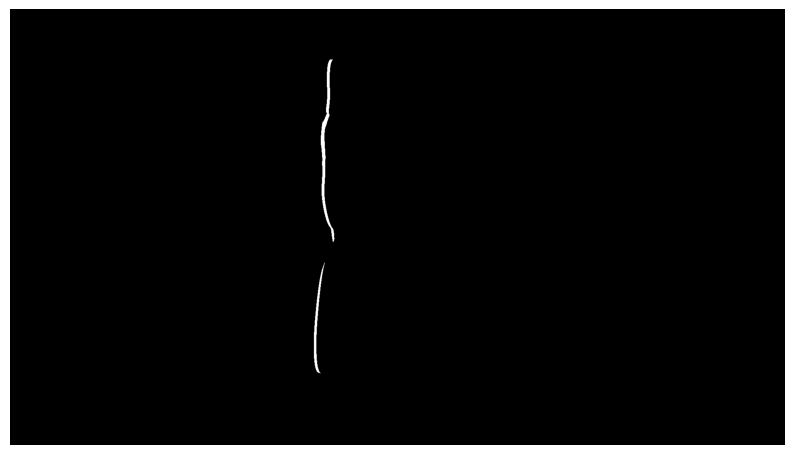

In [232]:

path = './scanRight/scan0014.png'
types = ["THRESH_BINARY", "THRESH_BINARY_INV", "THRESH_TRUNC","THRESH_TOZERO", "THRESH_TOZERO_INV"]
final_type = types[0]
threshold_value = 127


def thresh_image(path, value, type):
    img = cv2.imread(path)

    # Extract RED channel only (index 2 in BGR)
    red_channel = img[:, :, 2]

    ret, mask = cv2.threshold(red_channel,value,255,getattr(cv2, type))
    # mask_rgb = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

    return mask_rgb



# ==================================================================
binary = thresh_image(path, threshold_value, types[0])
binary_inv = thresh_image(path, threshold_value, types[1])
trunc = thresh_image(path, threshold_value, types[2])
to_zero = thresh_image(path, threshold_value, types[3])
to_zero_inv = thresh_image(path, threshold_value, types[4])


titles = ['BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [binary, binary_inv, trunc, to_zero, to_zero_inv]


# fig, axes = plt.subplots(2, 3, figsize=(16, 12))  # Bigger figure, 2x3 grid

# for i in range(5):
#     row = i // 3
#     col = i % 3
#     axes[row, col].imshow(images[i])
#     axes[row, col].set_title(titles[i], fontsize=14)
#     axes[row, col].axis('off')

# # Hide the 6th (empty) slot
# axes[1, 2].axis('off')

# plt.tight_layout()
# plt.show()

# 
plt.figure(figsize=(10, 10))
plt.imshow(binary)
plt.title(f'')
plt.axis('off')
plt.show()


### Threshold: all Images

GIF saved to laser_scan_animation.gif


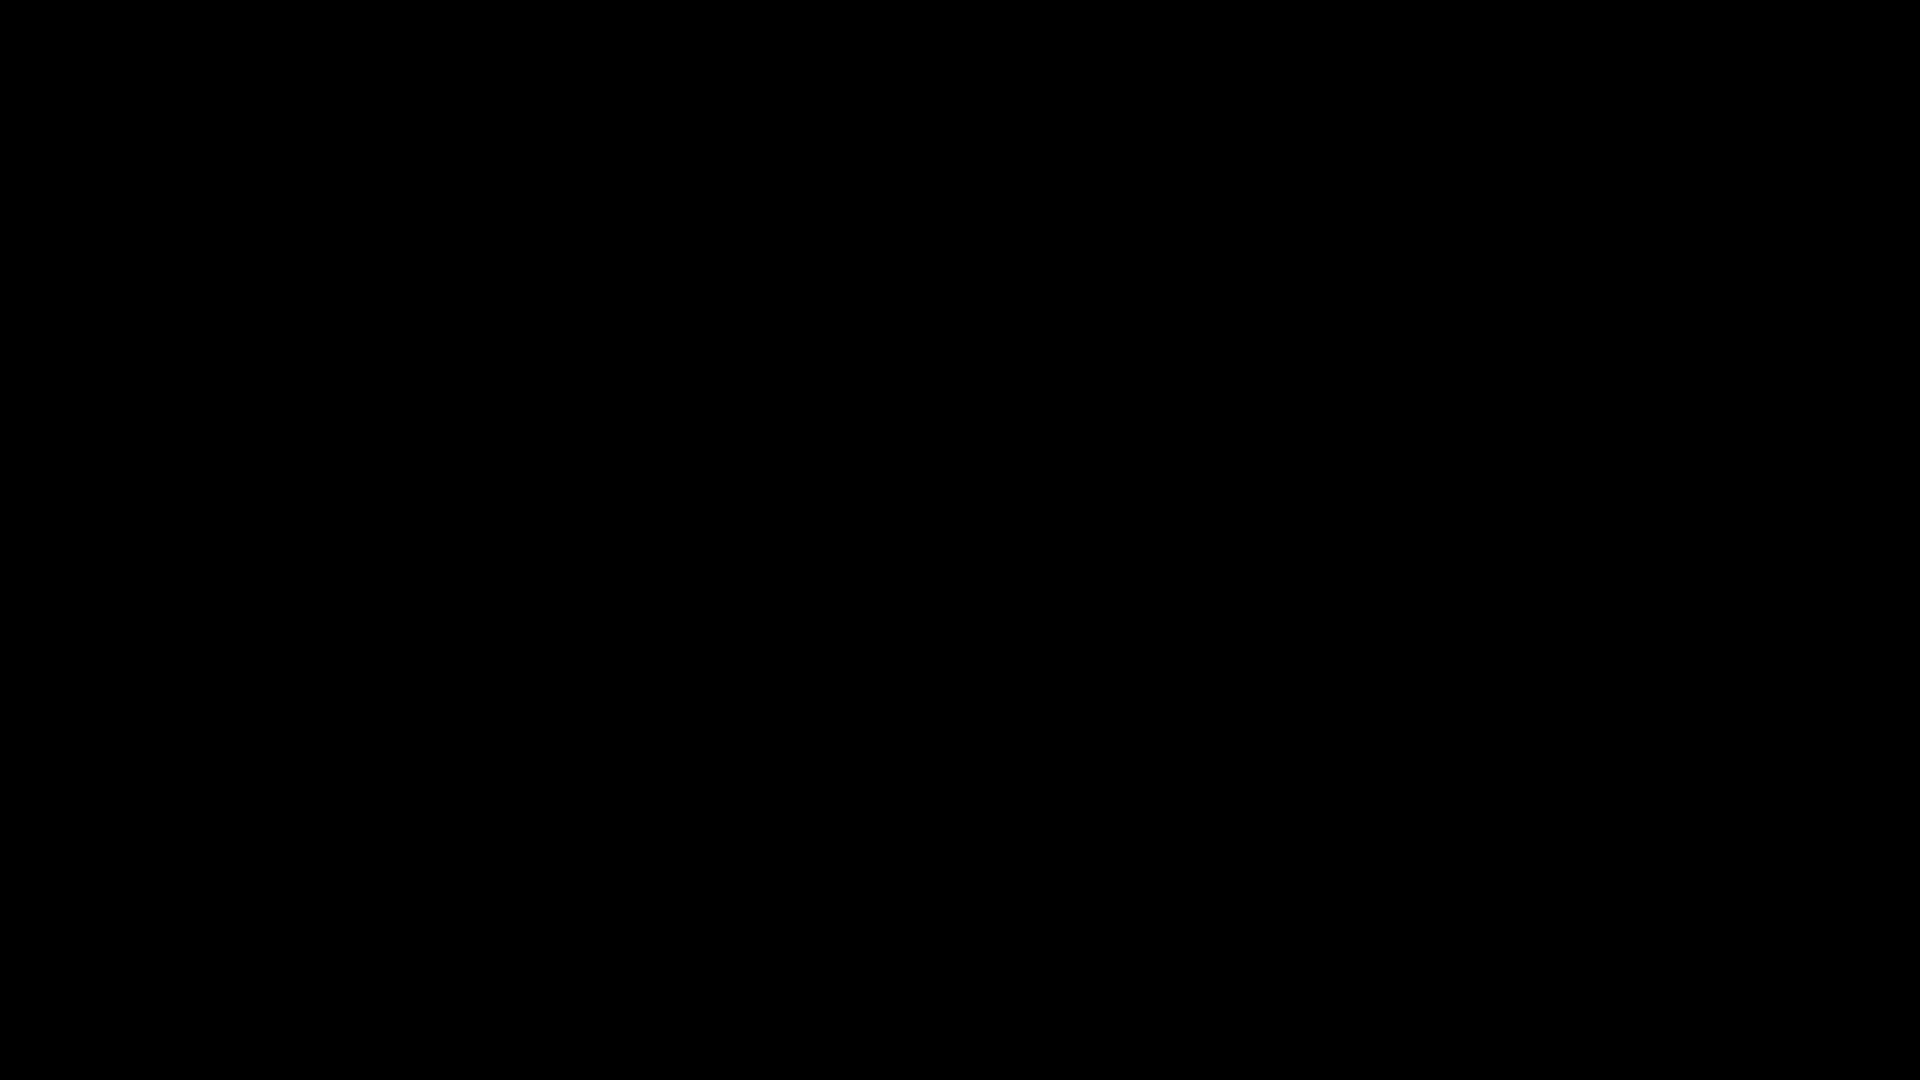

In [233]:
from PIL import Image
from IPython.display import Image as IPImage

frames = []
image_files = glob.glob("scanRight/*.png")

for i, file in enumerate(image_files):
    processed_img = thresh_image(file, threshold_value, types[0])

    # Convert to PIL Image
    pil_img = Image.fromarray(processed_img)
    frames.append(pil_img)

# Save as GIF
if frames:
    output_path = "laser_scan_animation.gif"
    frames[0].save(
        output_path,
        save_all=True,
        append_images=frames[1:],
        duration=100,  # milliseconds per frame
        loop=0  # infinite loop
    )
    print(f"GIF saved to {output_path}")

# Display the GIF in Jupyter
display(IPImage(output_path))

### Epilines: 1 Image

In [234]:
# Goal :
#         For x in left-image, find x' in right-image which must lie on L'.
#         Find epilines following this equation : L' = F * x

def extract_laser_pixels(binary_mask):
    """Extract laser pixel coordinates from binary mask."""
    laser_points = np.argwhere(binary_mask > 0)  # Returns (row, col), finds pixels with value > 0
    laser_points = laser_points[:, [1, 0]]  # Swap  (y, x) to (x, y)
    print(f"Extracted {laser_points.shape[0]} laser points.")
    return laser_points

def get_epilines(F, points):
    """ Find Epipolar L' = F @ x (x homogenous !!) """
    # Convert to homogeneous coordinates (add column of 1's)
    X_HOM = np.hstack([points, np.ones((points.shape[0], 1))])  # (N, 3)
    
    # Compute epilines: F @ x for each point
    epilines = (F @ X_HOM.T).T  # Transpose X_hom from (N, 3) to (3, N)- each row is [a, b, c]
    
    print(f"Computed {epilines.shape[0]} epipolar lines.")
    return epilines

def draw_epilines(img, points, color=(0, 255, 0), thickness=1):
    """draw ax + by + c = 0 """
    img_with_lines = img.copy()
    height, width = img_with_lines.shape[:2]

    for line in points:
        a, b, c = line
        
        # Calculate two points on the line at image boundaries
        # At x=0: y = -c/b
        # At x=width: y = -(a*width + c)/b
        
        if abs(b) > 1e-6:  # Avoid division by zero
            y0 = int(-c / b)
            y1 = int(-(a * width + c) / b)
            x0, x1 = 0, width
        else:  # Nearly vertical line
            x0 = x1 = int(-c / a)
            y0, y1 = 0, height
        
        # Draw line
        cv2.line(img_with_lines, (x0, y0), (x1, y1), color, thickness)
    
    return img_with_lines


#### Chessboard

=== Testing epilines on calibration images ===
Computed 49 epipolar lines.


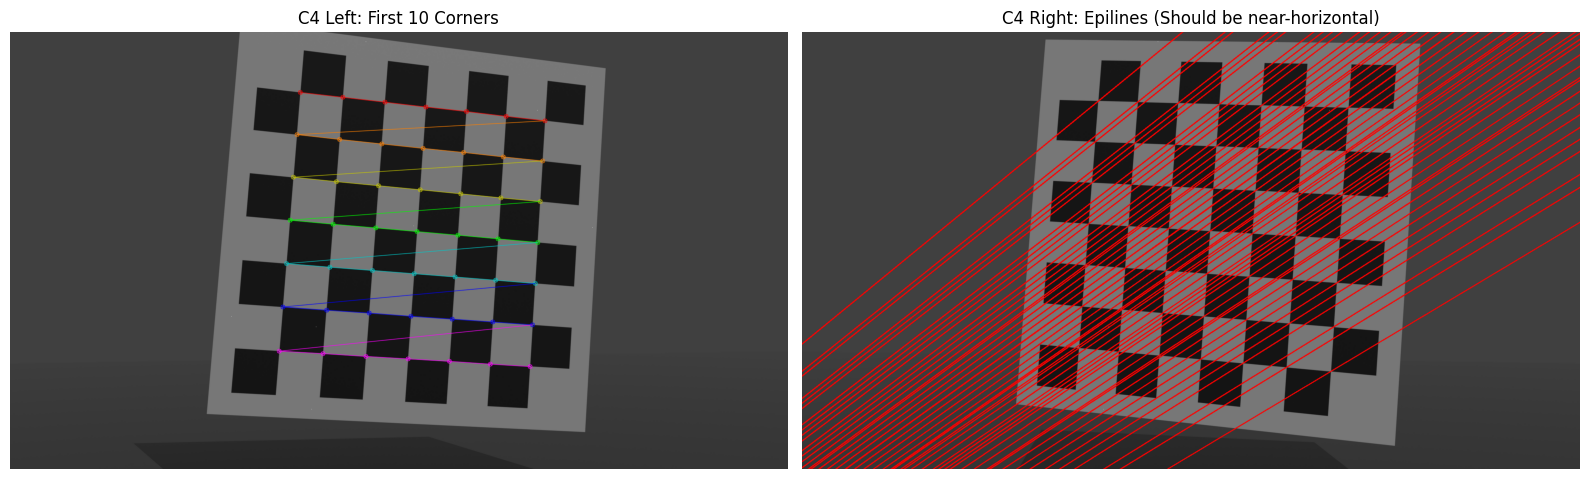

In [235]:


# =================================================================
# Epilines for chessboard
# TEST 1: Use chessboard c4 images (should give perfect horizontal lines)
print("=== Testing epilines on calibration images ===")

FUNDAMENTAL_MATRIX = F_manual_v2 #F_opencv  # Use the OpenCV computed F

# Extract a few chessboard corner points from left
result_test_left = detect_chessboard_corners("./chessboards/c4Left.png")
test_points = result_test_left['corners'].reshape(-1, 2) #[:10]  # First 10 corners

# Compute epilines for these known-good points
epilines_test = get_epilines(F_opencv, test_points)

# Draw on c4Right (the image F was calibrated on)
img_test_right = cv2.imread("./chessboards/c4Right.png")
img_test_right_rgb = cv2.cvtColor(img_test_right, cv2.COLOR_BGR2RGB)
img_test_epilines = draw_epilines(img_test_right_rgb, epilines_test, color=(255, 0, 0), thickness=2)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Show corners on left
ax1.imshow(result_test_left['image_with_corners'])
ax1.set_title('C4 Left: First 10 Corners')
ax1.axis('off')

# Show epilines on right
ax2.imshow(img_test_epilines)
ax2.set_title('C4 Right: Epilines (Should be near-horizontal)')
ax2.axis('off')

plt.tight_layout()
plt.show()


=== VERIFYING F MATRIX USAGE ===

Computed 5 epipolar lines.
Testing 5 point correspondences:

Pair 1:
  Left point:  (716.2, 150.8)
  Right point: (730.8, 172.0)
  Epiline: -0.003363x + -0.004103y + 3.163305 = 0
  Distance from right point to epiline: 0.012 pixels
  ✓ PASS (threshold: 2.0px)

Pair 2:
  Left point:  (821.4, 163.0)
  Right point: (828.4, 174.6)
  Epiline: -0.003296x + -0.004110y + 3.448273 = 0
  Distance from right point to epiline: 0.020 pixels
  ✓ PASS (threshold: 2.0px)

Pair 3:
  Left point:  (924.6, 174.9)
  Right point: (927.9, 177.3)
  Epiline: -0.003231x + -0.004118y + 3.727742 = 0
  Distance from right point to epiline: 0.037 pixels
  ✓ PASS (threshold: 2.0px)

Pair 4:
  Left point:  (1026.1, 186.6)
  Right point: (1029.6, 180.0)
  Epiline: -0.003166x + -0.004125y + 4.002605 = 0
  Distance from right point to epiline: 0.009 pixels
  ✓ PASS (threshold: 2.0px)

Pair 5:
  Left point:  (1125.8, 198.3)
  Right point: (1133.6, 182.8)
  Epiline: -0.003103x + -0.004132

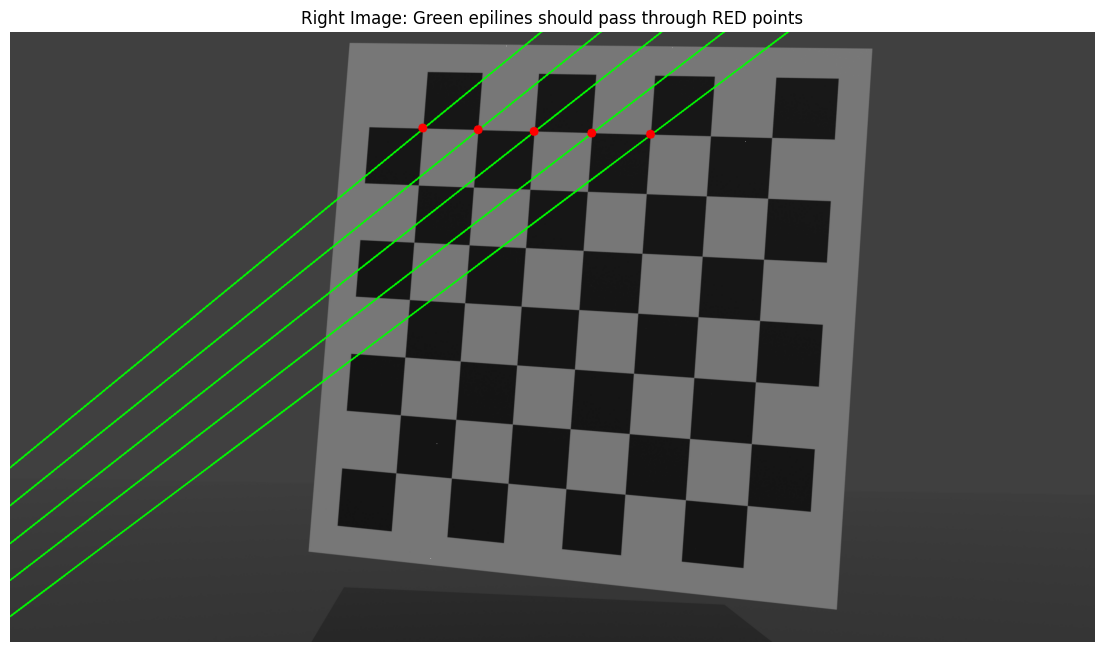


INTERPRETATION:
  - If red points lie ON green lines → F is correct
  - If red points are FAR from lines → F convention Error


In [236]:
# =============================================================
# CRITICAL TEST: Do epilines pass through corresponding points?
# =============================================================
print("=== VERIFYING F MATRIX USAGE ===\n")

# Get corresponding corners from BOTH images
result_test_left = detect_chessboard_corners("./chessboards/c4Left.png")
result_test_right = detect_chessboard_corners("./chessboards/c4Right.png")

pts_left_test = result_test_left['corners'].reshape(-1, 2)
pts_right_test = result_test_right['corners'].reshape(-1, 2)

# Take first 5 corner pairs
test_pairs = 5
pts_left_sample = pts_left_test[:test_pairs]
pts_right_sample = pts_right_test[:test_pairs]

# Compute epilines in RIGHT image from LEFT points
epilines_right = get_epilines(F_opencv, pts_left_sample)

print(f"Testing {test_pairs} point correspondences:\n")

# For each correspondence, check if right point lies on its epiline
for i in range(test_pairs):
    x_r, y_r = pts_right_sample[i]
    a, b, c = epilines_right[i]
    
    # Distance from point to line: |ax + by + c| / sqrt(a² + b²)
    distance = abs(a * x_r + b * y_r + c) / np.sqrt(a**2 + b**2)
    
    print(f"Pair {i+1}:")
    print(f"  Left point:  ({pts_left_sample[i][0]:.1f}, {pts_left_sample[i][1]:.1f})")
    print(f"  Right point: ({x_r:.1f}, {y_r:.1f})")
    print(f"  Epiline: {a:.6f}x + {b:.6f}y + {c:.6f} = 0")
    print(f"  Distance from right point to epiline: {distance:.3f} pixels")
    print(f"  {'✓ PASS' if distance < 2.0 else '✗ FAIL'} (threshold: 2.0px)\n")

# Visual check
img_test_right = cv2.imread("./chessboards/c4Right.png")
img_test_right_rgb = cv2.cvtColor(img_test_right, cv2.COLOR_BGR2RGB)
img_visual = draw_epilines(img_test_right_rgb, epilines_right, color=(0, 255, 0), thickness=2)

# Draw the corresponding points in RED to see if they lie on the green epilines
for i in range(test_pairs):
    x, y = pts_right_sample[i]
    cv2.circle(img_visual, (int(x), int(y)), 8, (255, 0, 0), -1)

plt.figure(figsize=(14, 10))
plt.imshow(img_visual)
plt.title('Right Image: Green epilines should pass through RED points')
plt.axis('off')
plt.show()

print("\n" + "="*60)
print("INTERPRETATION:")
print("  - If red points lie ON green lines → F is correct")
print("  - If red points are FAR from lines → F convention Error")
print("="*60)

#### Suzanne

Extracted 23406 laser points.
Computed 23406 epipolar lines.


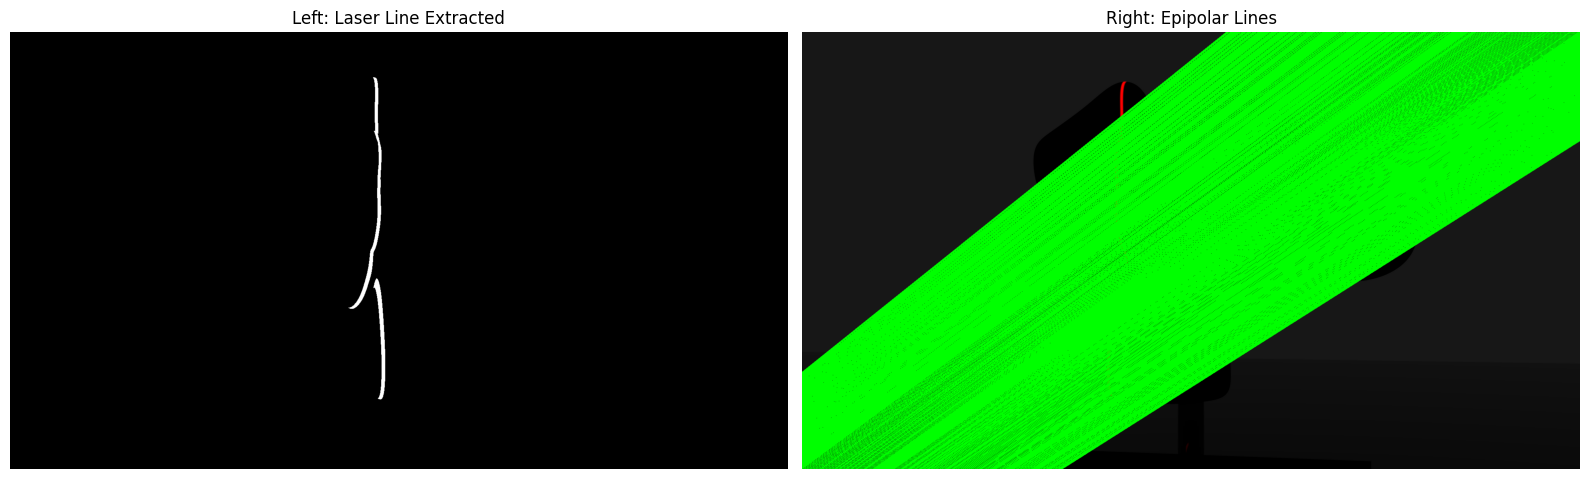

In [237]:
# Left image processing
path_left = './scanLeft/0014.png'
path_right = './scanRight/scan0014.png'

# Get img, filter only the laser and extract points coordinates from laser line
masked_img = thresh_image(path_left, threshold_value, final_type)
laser_points_left = extract_laser_pixels(masked_img)

# Compute epilines in RIGHT image using LEFT points
epilines_right = get_epilines(F_opencv, laser_points_left)

# Load and draw epilines on RIGHT image

img_right = cv2.imread(path_right)
img_right_rgb = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
img_with_epilines = draw_epilines(img_right_rgb, epilines_right, color=(0, 255, 0), thickness=1)

# =========================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(masked_img)
ax1.set_title('Left: Laser Line Extracted')
ax1.axis('off')

ax2.imshow(img_with_epilines)
ax2.set_title('Right: Epipolar Lines')
ax2.axis('off')

plt.tight_layout()
plt.show()

### Epilines: All Images

Extracted 0 laser points.
Computed 0 epipolar lines.


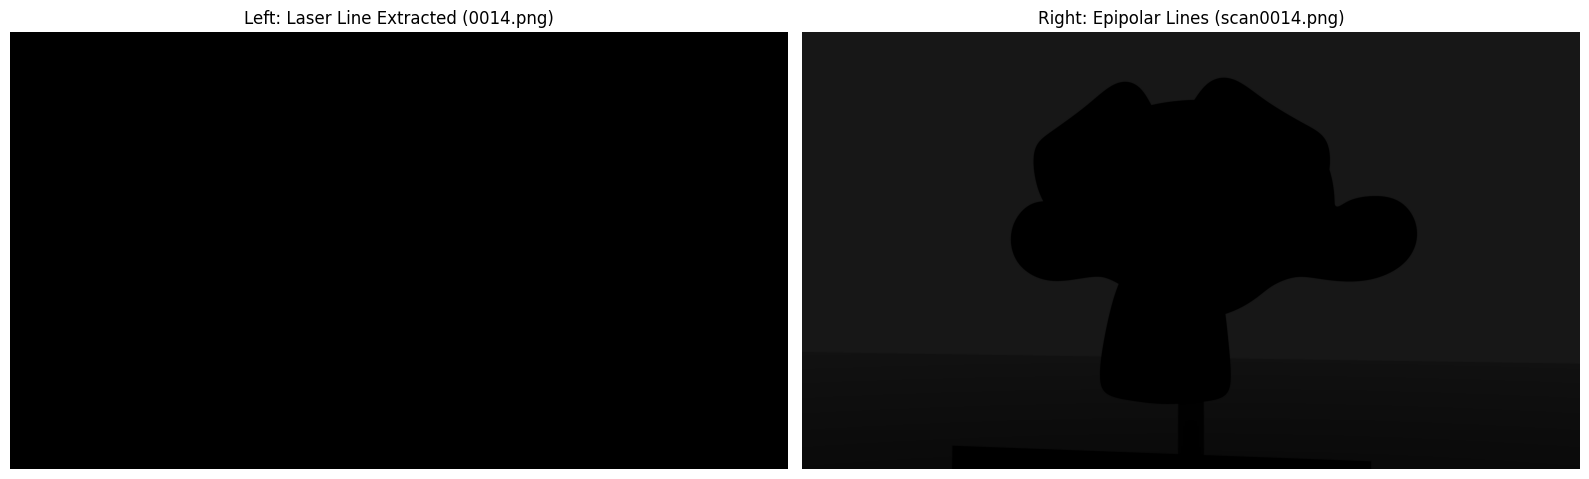

In [238]:
def find_all_lines(left_folder, right_folder):
    left_images = sorted(glob.glob(f"{left_folder}/*.png"))
    right_images = sorted(glob.glob(f"{right_folder}/*.png"))
    
    for left_path, right_path in zip(left_images, right_images):
        # Process left image
        masked_img_left = thresh_image(left_path, threshold_value, final_type)
        laser_points_left = extract_laser_pixels(masked_img_left)
        
        # Compute epilines in RIGHT image
        epilines_right = get_epilines(F_opencv, laser_points_left)
        
        # Load and draw epilines on RIGHT image
        img_right = cv2.imread(right_path)
        img_right_rgb = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
        img_with_epilines = draw_epilines(img_right_rgb, epilines_right, color=(0, 255, 0), thickness=1)

        return masked_img_left, img_with_epilines



masked_img_left, img_with_epilines = find_all_lines('./scanLeft', './scanRight')
# ======================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(masked_img_left)
ax1.set_title(f'Left: Laser Line Extracted ({path_left.split("/")[-1]})')
ax1.axis('off')

ax2.imshow(img_with_epilines)
ax2.set_title(f'Right: Epipolar Lines ({path_right.split("/")[-1]})')
ax2.axis('off')

plt.tight_layout()
plt.show()